## **Introduction**

### MEGMA
**MEGMA** is short for metagenomic **M**icrobial **E**mbedding, **G**rouping, and **M**apping **A**lgorithm (MEGMA) , which is a further step development of **AggMap** that specific for metagenomic data learning. **MEGMA** is developed to transform the tabular metagenomic data into spatially-correlated color image-like 2D-representations, named as the 2D-microbiomeprints (3D tensor data in the form of row, column and channel). 2D-microbiomeprints are multichannel feature maps (Fmaps) and are the inputs of ConvNet-based AggMapNet models. 

![MEGMA](./MEGMA.png)

**MEGMA** is released in the **aggmap** package, in this example, we will show how to employ the **aggmap** package to perform **MEGMA** on the cross-nation datasets of metagenomics.

### Metagenomic Cross-Nation Data and Tasks

The metagenomic cross-nation data covers 849 gut microbial species from fecal samples of total 575 subjects (Colorectal cancers, CRCs or healthy controls, CTRs) compiled by [Wirbel et al.(Nat. Med. 25, 679-689, 2019)](https://www.nature.com/articles/s41591-019-0406-6). It contains five metagenomic datasets from five separate studies in five nations (**FRA**: France, **AUS**: Australia, **DEU**: Germany, **CHN**: China, and **USA**: America). 
             
<div align="center">
   <span style="font-weight:bold;">Table 1. Metagenomic cross-nation data.</span>
</div>



|Dataset|# Case (CRC)|# Control (CTR)|# Species|Download|
|:----|:----|:----|:----|:----|
|**AUS**|46|63|849|[label](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/MEGMA/dataset/AUS_dfy.csv), [data](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/MEGMA/dataset/AUS_dfx.csv)|
|**CHN**|74|54|849|[label](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/MEGMA/dataset/CHN_dfy.csv), [data](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/MEGMA/dataset/CHN_dfx.csv)|
|**DEU**|60|60|849|[label](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/MEGMA/dataset/DEU_dfy.csv), [data](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/MEGMA/dataset/DEU_dfx.csv)|
|**FRA**|53|61|849|[label](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/MEGMA/dataset/FRA_dfy.csv), [data](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/MEGMA/dataset/FRA_dfx.csv)|
|**USA**|52|52|849|[label](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/MEGMA/dataset/USA_dfy.csv), [data](https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/MEGMA/dataset/USA_dfx.csv)|


The tasks are to build classfication models to classify CRCS from CTRs, and to identify the important microbial species that contribute to CRCs. Each microbe is a feature point in the classfication model, therefore, we need to calculate the feature importance to get the importance score of the microbes. Since we have five independent datasets that from five countries, we can build the model on one country data and test the model performance on the rest of the countries, we called this a study-to-study transfer (**STST**, model trained on one nation data and tested on the rest nations) experiment. The **STST** can tell us the real performance of the metagenomc machine learning models in the application of the external data. Therefore, in this example, the study-to-study transfer will be used for the evaluation of the performance of the metagenomic prediction models and the consistency of the across-nation biomarker discovery. 

## **2D-microbiomeprints generation by MEGMA**

**MEGMA** is an unsupervised learning method, therefore, the 2D-microbiomeprints can be generated by the data without label. We can generate the 2D-microbiomeprints based on only one country data or all of the data, the correlation distance or similar matrix of the microbes can be different when calculated by different data. But generally, the correlation matrix calculated based on the whole data can be more robust and accurately (Because microbe-to-microbe correlation distances/similarities are measured with more samples), and consequently, the 2D-microbiomeprints can be more structured and patterned. In this example, we will show how to generate the 2D-microbiomeprints based on one country data or the whole data. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggMapNet
from aggmap import show, loadmap

2022-08-02 19:04:32.353857: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### MEGMA pre-trained on one country data only

We first to pre-train the unsupervied MEGMA on one country data only (such as the CHN data), later we can transform the data from the rest of the country by the trained MEGMA.

In [14]:
country = 'CHN' # 'USA', 'FRA', 'AUS', 'DEU'

url = 'https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/MEGMA/dataset/'
dfx = pd.read_csv(url + '%s_dfx.csv' % country, index_col='Sample_ID')
dfy = pd.read_csv(url + '%s_dfy.csv' % country, index_col='Sample_ID')

In [3]:
dfx[dfx.columns[:4]].head(8)

,Clostridium saccharogumia [ref_mOTU_v2_0473],Clostridium innocuum [ref_mOTU_v2_0643],Clostridium sp. KLE 1755 [ref_mOTU_v2_0860],Clostridium scindens [ref_mOTU_v2_0883]
Sample_ID,,,,
ERR1018185,0.0,0.000094,0.000094,0.000188
ERR1018186,0.0,0.000138,0.000827,0.000276
ERR1018187,0.0,0.000091,0.000183,0.000183
ERR1018188,0.0,0.000312,0.000104,0.000312
ERR1018189,0.0,0.000000,0.000000,0.000000
ERR1018190,0.0,0.000184,0.000552,0.000184
ERR1018191,0.0,0.000100,0.000000,0.004593
ERR1018192,0.0,0.003788,0.000131,0.000000


#### Microbial Embedding & Grouping

To make the distance can be measured accurately, the abundance data will be log-transformed first.

In the initialization stage, **MEGMA** supports a varity of metric to measure the distances between the microbes. The default `metric` is the correlation distance. Importantly, **MEGMA** also supports to input a pre-difined distance matrix ( the `info_distance` parameter) for of microbes. 

In the fitting stage, **MEGMA** default uses the UMAP (the `emb_method` parameter) method to perform the embedding of the microbes, the parameter `cluster_channels` is for the grouping of the microbes, it uses the hierarchical clustering algrothm to generate the subgroups of the microbes. Importantly, **MEGMA** also supports to input a pre-difined microbial subgroup list (i.e., the `feature_group_list` parameter, it can be used to custmise the


). More information about **Embedding & Grouping** can be see [here](https://bidd-aggmap.readthedocs.io/en/latest). The parameter `var_thr` can be used to filter out some microbes in very low variances.


In [4]:
dfx = np.log(dfx + 1e-8)
megma = AggMap(dfx, metric = 'correlation', info_distance = None,)
megma = megma.fit(emb_method='umap', cluster_channels = 5, feature_group_list=[], var_thr=-1, random_state=888, verbose = 0)

2022-08-02 19:04:33,780 - INFO - [bidd-aggmap] - Calculating distance ...
2022-08-02 19:04:33,804 - INFO - [bidd-aggmap] - the number of process is 16


100%|#############################################################################################################################################| 849/849 [00:00<00:00, 5750.87it/s]


2022-08-02 19:05:02,646 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2022-08-02 19:05:04,753 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2022-08-02 19:05:05,062 - INFO - [bidd-aggmap] - Finished


The object **megma**  can be dumped in your disk and then loaded next time by `loadmap`. Basically, the **megma** object is same as a trained model, once it is fitted by the unlabelled data, it can be used to transform an 1D vector into 3D tensor, i.e., the multichannel Fmaps.

In [5]:
save_name = './%s.megma' % country
megma.save(save_name)

#delete megma from memory
del megma 

#reload megma from disk
megma = loadmap(save_name)

#### Metagenomic Data Transformation

In the transformation stage, z-score standard data scaling can be performed by `scale_method`. The `megma.batch_transform` method can transform a set of vectors, while the `megma.transform` method is to transform one 1D vector. 

In [6]:
X = megma.batch_transform(dfx.values, scale_method = 'standard')
X.shape

100%|###############################################################################################################################################| 128/128 [00:01<00:00, 73.51it/s]


(128, 30, 29, 5)

#### 2D-microbiomeprints visulization

In [7]:
megma.plot_grid(htmlname = 'grid_%s' % country)

2022-08-02 19:05:06,910 - INFO - [bidd-aggmap] - generate file: ./grid_CHN_feature points_849_correlation_umap_mp
2022-08-02 19:05:06,918 - INFO - [bidd-aggmap] - save html file to ./grid_CHN_feature points_849_correlation_umap_mp


In [8]:
idx = dfy.reset_index().groupby(['Country', 'Group']).apply(lambda x:x.index.tolist())
idx

Country  Group
CHN      CRC      [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15...
         CTR      [8, 10, 18, 20, 24, 32, 47, 48, 49, 50, 51, 52...
dtype: object

In [11]:
def plot(X, megma, rows, fname = './Country1_fmp.png'):
    n = 5
    fontsize = 40
    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(22,9), sharex = True, sharey = True)
    row_names = [', '.join(i) for i in rows]
    for row, row_ax in zip(rows, axes):
        pidx = idx.loc[row][:n]        
        for pid, ax in zip(pidx, row_ax):
            cid = row[0]
            pid_name = '%s-%s' % (cid, pid)
            x = X[pid]
            show.imshow(x, ax = ax,  mode = 'dark', color_list= pd.Series(megma.colormaps).tolist(), x_max=3, vmin=-0.5, vmax=0.9)
            ax.set_title(pid_name, fontsize = fontsize) 
    for ax, row in zip(axes[:,0], row_names):
        ax.set_ylabel(row.split(',')[1], fontsize = fontsize)  
    fig.tight_layout()
    fig.savefig(fname, bbox_inches='tight', dpi=400) 

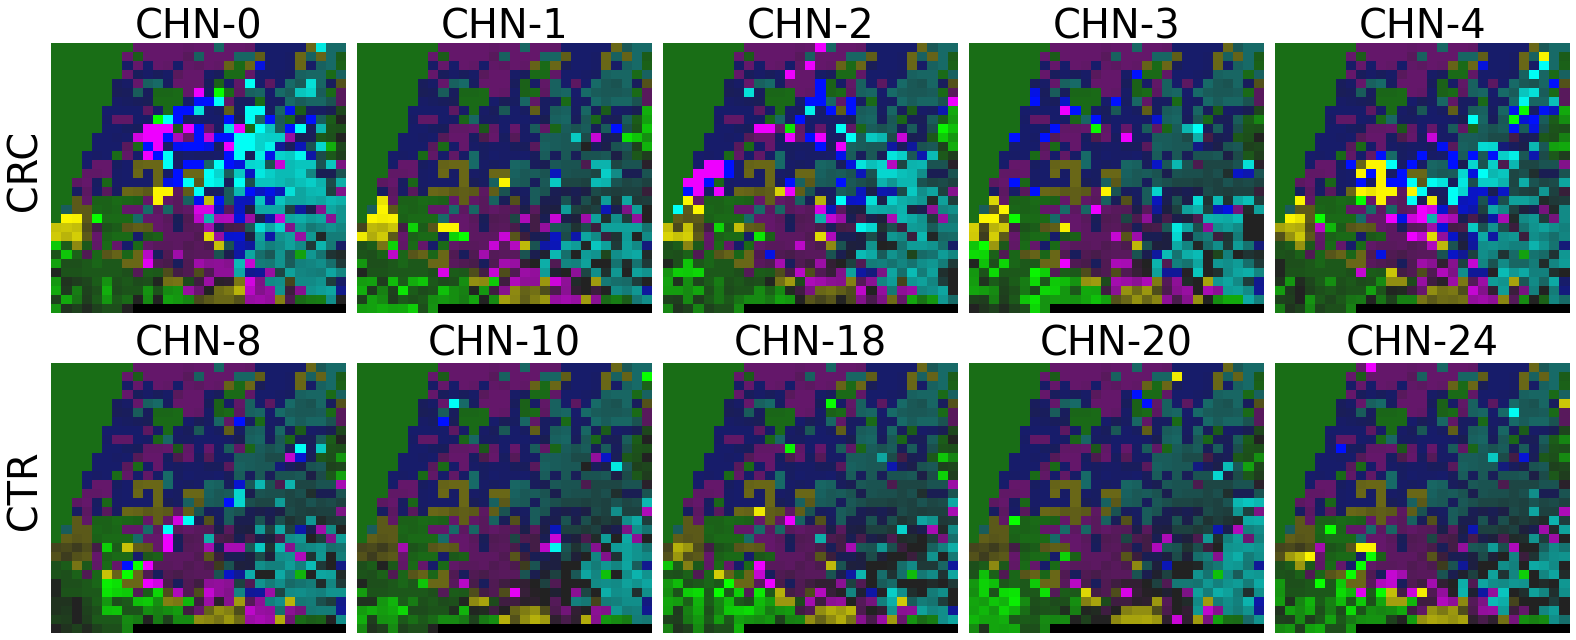

In [12]:
rows = idx.index.tolist()
rows = rows[:2]
plot(X, megma, rows, fname = './fmp_%s.png' % country)

### Well-trained MEGMA to transform the data of the rest of countries

We have trained the MEGMA based on one country data, of course it now can transform the metagenomic vector data of this country, but it can also be used to transform the metagenomic vector data of the rest of the countries.

100%|#############################################################################################################################################| 109/109 [00:00<00:00, 2324.26it/s]


Trained MEGMA has transformed 3D tensor for AUS data


100%|#############################################################################################################################################| 128/128 [00:00<00:00, 2361.72it/s]


Trained MEGMA has transformed 3D tensor for CHN data


100%|#############################################################################################################################################| 120/120 [00:00<00:00, 2218.00it/s]


Trained MEGMA has transformed 3D tensor for DEU data


100%|#############################################################################################################################################| 114/114 [00:00<00:00, 2451.19it/s]


Trained MEGMA has transformed 3D tensor for FRA data


100%|##############################################################################################################################################| 104/104 [00:00<00:00, 558.47it/s]


Trained MEGMA has transformed 3D tensor for USA data


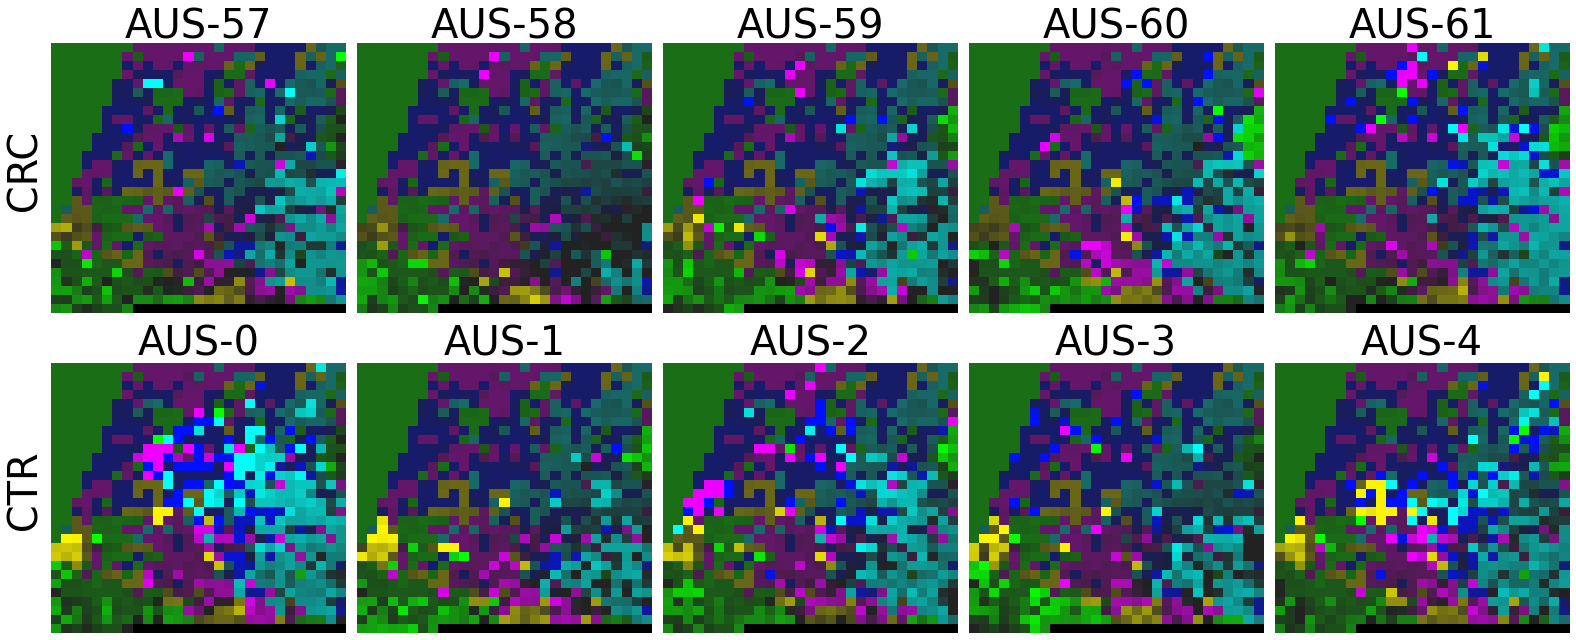

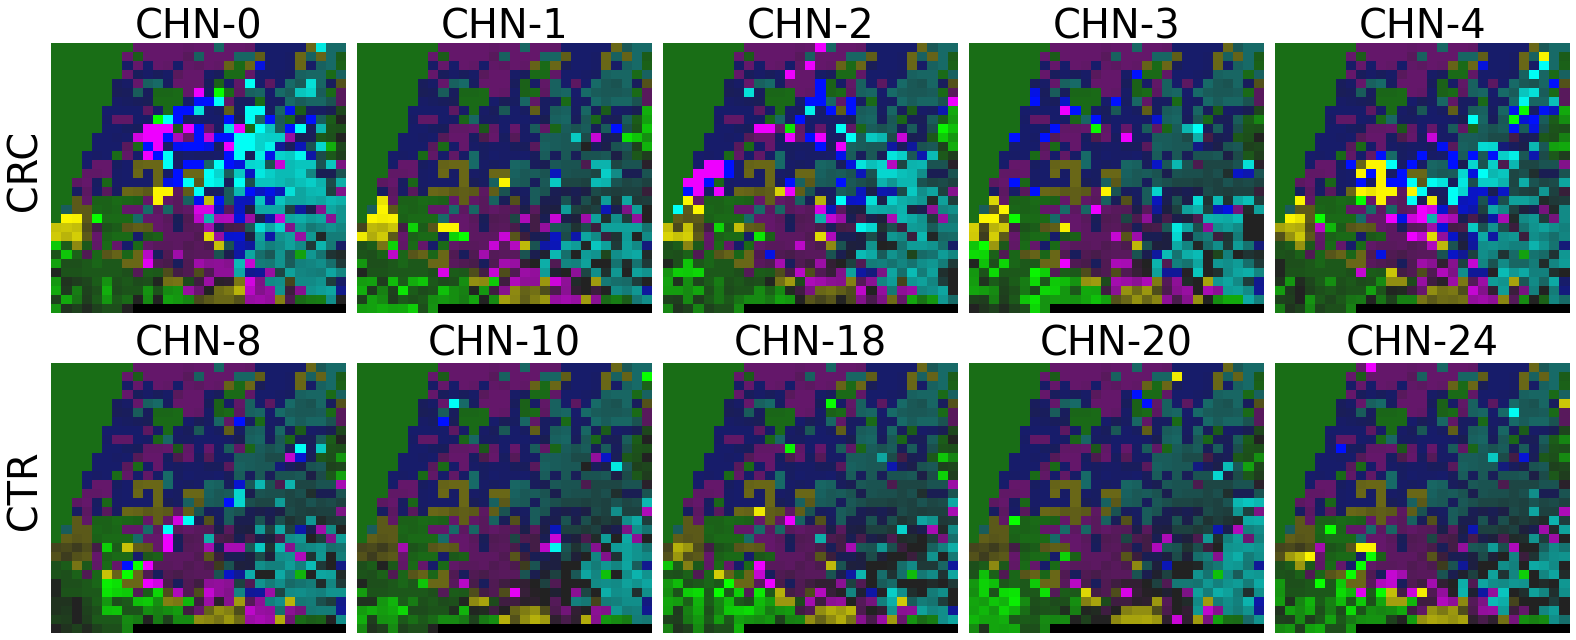

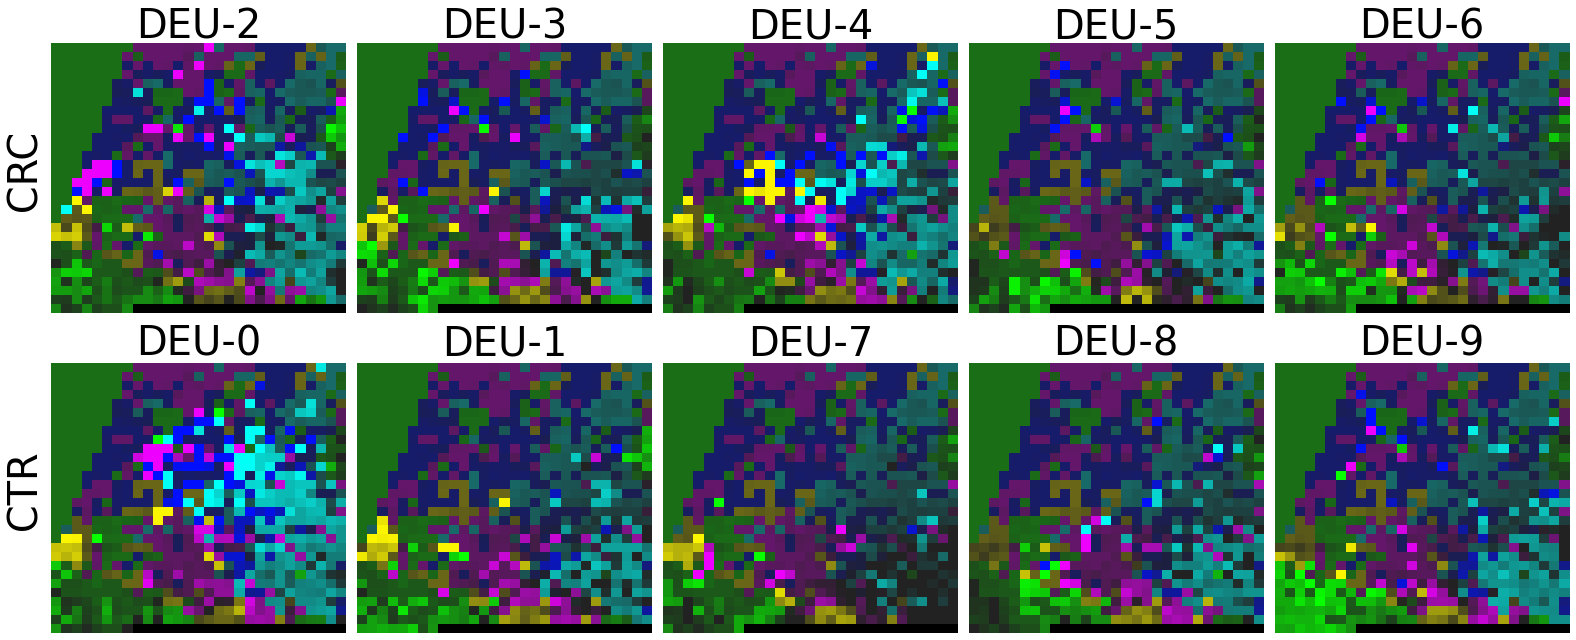

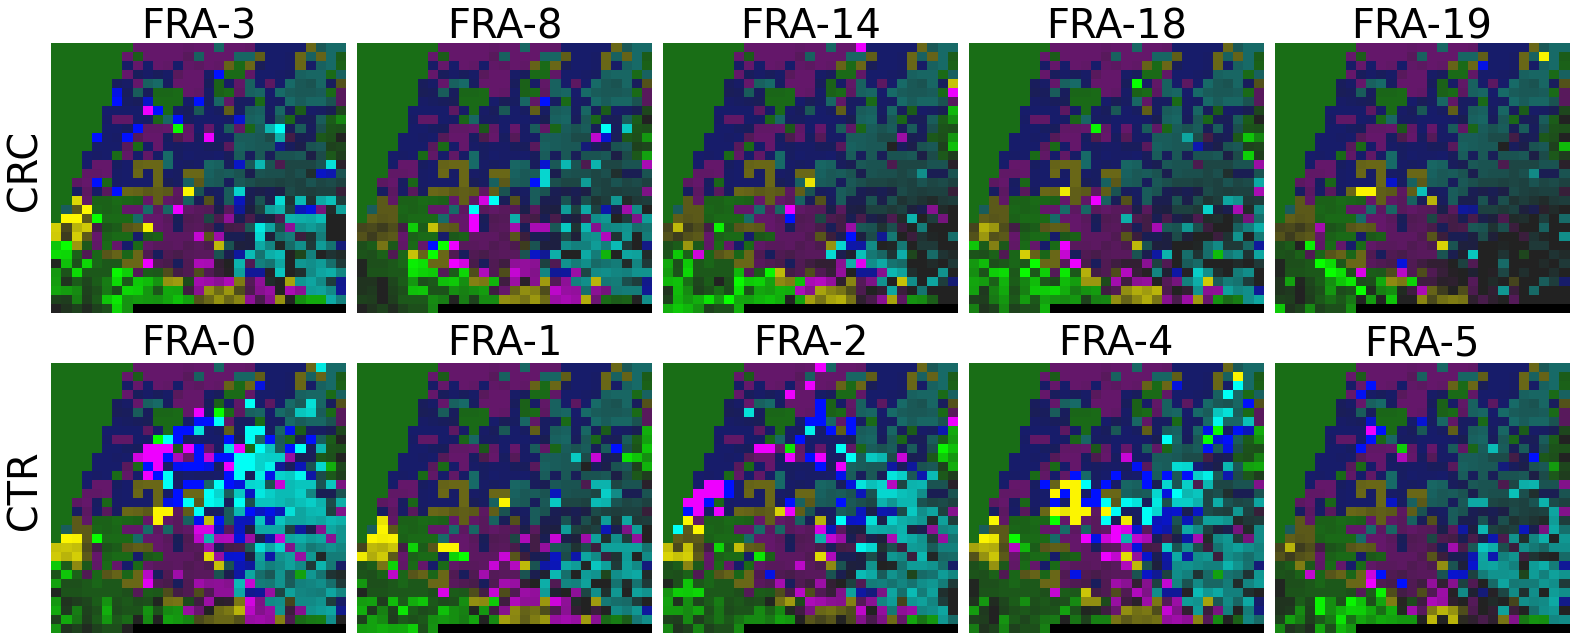

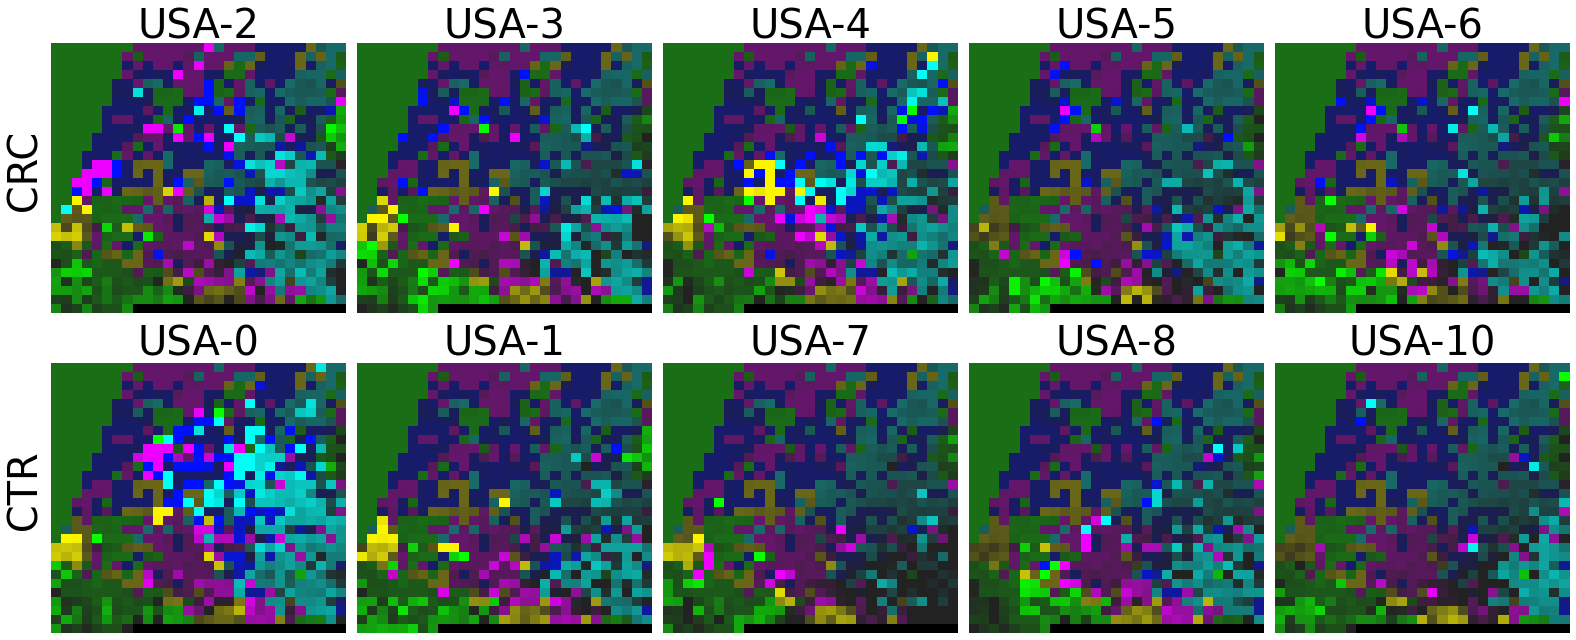

In [19]:
countres = ['AUS', 'CHN', 'DEU', 'FRA', 'USA']
Xs = []
for country in countres:
    dfx_vector = pd.read_csv(url + '%s_dfx.csv' % country, index_col='Sample_ID')
    dfx_vector = np.log(dfx_vector + 1e-8)    
    X_tensor = megma.batch_transform(dfx_vector.values)
    Xs.append(X_tensor)
    
    print('Trained MEGMA has transformed 3D tensor for %s data' % country)
    
    dfy = pd.read_csv(url + '%s_dfy.csv' % country, index_col='Sample_ID')
    idx = dfy.reset_index().groupby(['Country', 'Group']).apply(lambda x:x.index.tolist())
    rows = idx.index.tolist()
    rows = rows[:2]
    plot(X, megma, rows, fname = './fmp_%s.png' % country)